<a href="https://colab.research.google.com/github/kozoB/steam-sarcasm-detection/blob/main/Steam_Reviews_Sarcasm_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam Reviews Sarcasm Detection

# Imports

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Load Dataset

In [28]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read the CSV file
dataset_path = '/content/drive/MyDrive/Masters Degree/NLP Course/Steam Reviews Sarcasm Detection Project/dataset/steam_reviews_dataset_labeled.csv'
steam_reviews = pd.read_csv(dataset_path)

# Display the first few rows
steam_reviews.head()

Mounted at /content/drive


,app_id,app_name,review_text,review_score,review_votes,sarcasm_label
0,10,Counter-Strike,Ruined my life.,1,0,1
1,10,Counter-Strike,This game saved my virginity.,1,0,1
2,10,Counter-Strike,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1
3,10,Counter-Strike,"Easy to learn, hard to master.",1,1,0
4,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1,1


In [29]:
print(f"steam_reviews shape:\n{steam_reviews.shape}\n")
print(f"{steam_reviews['sarcasm_label'].value_counts()}")

steam_reviews shape:
(563, 6)

sarcasm_label
0    313
1    250
Name: count, dtype: int64


# Exploratory Data Analysis (EDA) and Feature Engineering

## Label Distribution

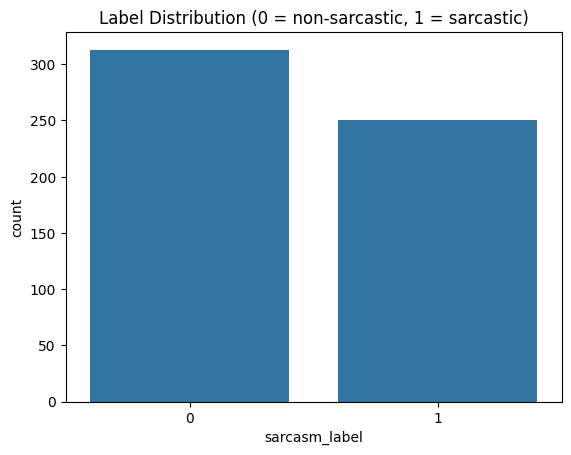

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sarcasm_label', data=steam_reviews)
plt.title("Label Distribution (0 = non-sarcastic, 1 = sarcastic)")
plt.show()

## Review Score vs. Sarcasm Correlation

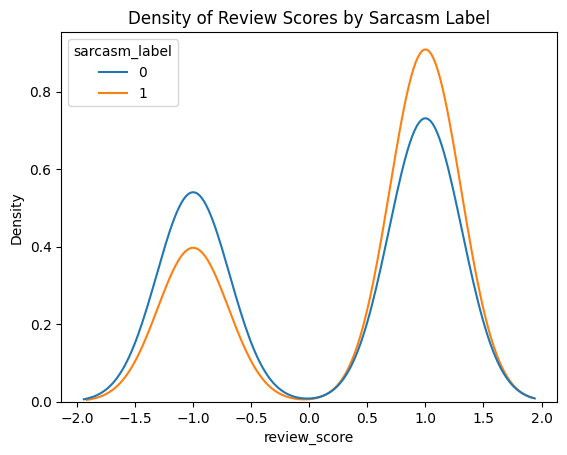

In [31]:
sns.kdeplot(data=steam_reviews, x='review_score', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Scores by Sarcasm Label")
plt.show()

This plot shows the distribution of review scores for sarcastic and non-sarcastic Steam reviews. While both classes contain a mix of positive (+1) and negative (-1) review scores, sarcastic reviews tend to be skewed more toward positive scores. This suggests that many sarcastic reviews outwardly "recommend" the game, likely using irony to express dissatisfaction - a common sarcasm pattern. In contrast, non-sarcastic reviews display a more balanced distribution between negative and positive scores. This highlights a key challenge in sarcasm detection: sarcastic comments may appear positive in rating but convey negative sentiment in text. As a result, the review_score feature may be misleading on its own, but when combined with text, it becomes a valuable signal for distinguishing genuine praise from sarcasm.

## Density of Review Votes By Srcasm Label

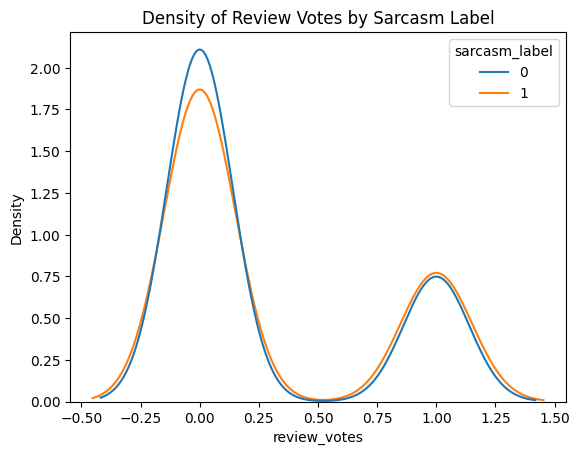

In [32]:
sns.kdeplot(data=steam_reviews, x='review_votes', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Votes by Sarcasm Label")
plt.show()

The distribution of 'review_votes' reveals that both sarcastic and non-sarcastic reviews typically receive few or no votes, with a sharp peak near zero.
However, sarcastic reviews show a slightly higher density at the upper end, suggesting that sarcastic content may be more engaging or memorable, making it more likely to be voted as helpful by other users. While this feature alone may not be strongly discriminative, it could still carry subtle signal when combined with textual features in a multimodal sarcasm detection model. Therefore, 'review_votes' is retained as a metadata feature during training.

## Density of Sentiment By Sarcasm Label

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


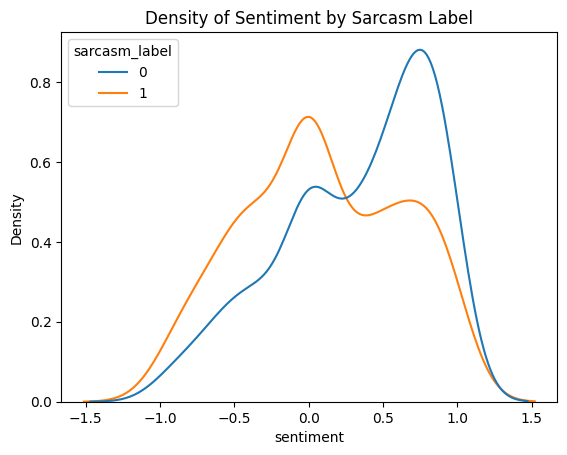

In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

steam_reviews['sentiment'] = steam_reviews['review_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

sns.kdeplot(data=steam_reviews, x='sentiment', hue='sarcasm_label', common_norm=False)
plt.title("Density of Sentiment by Sarcasm Label")
plt.show()

Sentiment analysis using VADER reveals that sarcastic reviews tend to cluster around neutral or slightly negative sentiment scores, whereas non-sarcastic reviews skew strongly positive. This divergence highlights a common sarcasm pattern: expressing negative opinions using superficially positive language. The sentiment distribution supports the inclusion of sentiment polarity as a metadata feature and also suggests that mismatches between sentiment and review score may serve as effective sarcasm indicators.

## Bidirectional Sentiment Mismatch By Sarcasm Label

In [34]:
# Sentiment mismatch
steam_reviews['sentiment_mismatch'] = (
    ((steam_reviews['review_score'] == 1) & (steam_reviews['sentiment'] < 0.2)) |
    ((steam_reviews['review_score'] == -1) & (steam_reviews['sentiment'] > 0.2))
).astype(int)


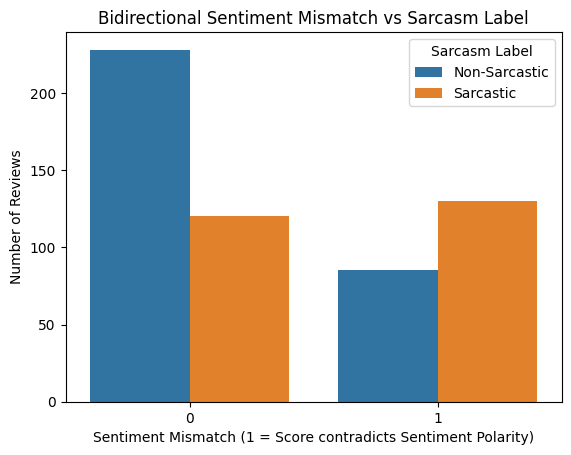

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_mismatch', hue='sarcasm_label', data=steam_reviews)
plt.title("Bidirectional Sentiment Mismatch vs Sarcasm Label")
plt.xlabel("Sentiment Mismatch (1 = Score contradicts Sentiment Polarity)")
plt.ylabel("Number of Reviews")
plt.legend(title='Sarcasm Label', labels=['Non-Sarcastic', 'Sarcastic'])
plt.show()


The sentiment_mismatch feature flags reviews where the recommendation score contradicts the sentiment of the review text — either a positive score with neutral or negative sentiment, or a negative score with positive sentiment. This bidirectional approach captures a broader range of sarcasm patterns. As shown in the plot, sarcastic reviews are significantly more likely to exhibit such mismatches, whereas non-sarcastic reviews tend to show consistency between rating and sentiment. This supports the idea that sarcasm often relies on ironic contrast between what is said (text) and what is implied (rating), making sentiment_mismatch a valuable and interpretable metadata feature for sarcasm detection models.

In [36]:
# Has ALL CAPS words
steam_reviews['has_caps'] = steam_reviews['review_text'].str.contains(r'[A-Z]{3,}').astype(int)

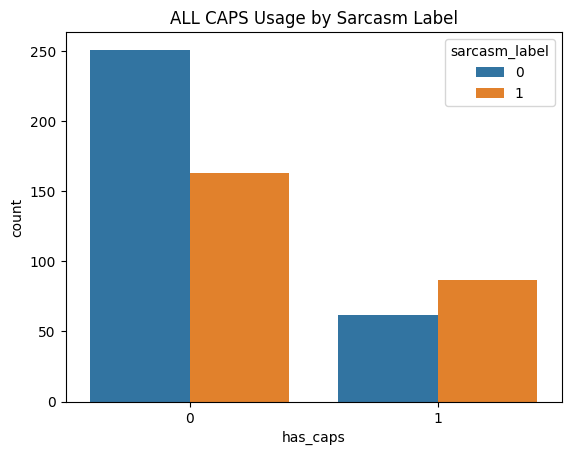

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='has_caps', hue='sarcasm_label', data=steam_reviews)
plt.title("ALL CAPS Usage by Sarcasm Label")
plt.show()

In [38]:
from scipy.stats import pointbiserialr

corr, p = pointbiserialr(steam_reviews['has_caps'], steam_reviews['sarcasm_label'])
print(f"{'has_caps'}: r = {corr:.3f}, p = {p:.3f}")

has_caps: r = 0.169, p = 0.000


In [39]:
# Prepare the features and labels for modeling by removing game-specific identifiers
# 'app_id' and 'app_name' are excluded to prevent model overfitting to specific games
steam_review_features = steam_reviews.drop(columns=['app_id', 'app_name'])

In [40]:
steam_review_features

,review_text,review_score,review_votes,sarcasm_label,sentiment,sentiment_mismatch,has_caps
0,Ruined my life.,1,0,1,-0.4767,1,0
1,This game saved my virginity.,1,0,1,0.4215,0,0
2,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1,0.9098,0,0
3,"Easy to learn, hard to master.",1,1,0,0.3612,0,0
4,"No r8 revolver, 10/10 will play again.",1,1,1,0.0516,1,0
...,...,...,...,...,...,...,...
558,I tried this when it was free to play. It is j...,-1,0,0,0.4019,1,0
559,"The mechanics of this game are so broken, it's...",1,0,1,0.0445,1,0
560,They misspelled 'Died' 10/10,1,0,1,0.0000,1,0
561,.99 cents and it still isn't worth the money.,-1,0,0,-0.1695,0,0


## Split Data To Train And Test Sets

In [41]:
from sklearn.model_selection import train_test_split

# Randomized split (90% train, 10% test)
train_df, test_df = train_test_split(
    steam_review_features,
    test_size=0.1,
    stratify=steam_review_features['sarcasm_label'],  # Ensures balanced class distribution
    random_state=42      # For reproducibility
)

# Review Text Only Experiment

### Create Train And Test Sets with Relevant Features

In [42]:
# Text-only versions for model experiment
text_train_df = train_df[['review_text', 'sarcasm_label']]
text_test_df = test_df[['review_text', 'sarcasm_label']]

## Zero Shot

In [43]:
from transformers import pipeline
from sklearn.metrics import classification_report
import pandas as pd

# Initialize zero-shot pipeline with a pre-trained model
zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model="FacebookAI/roberta-large-mnli"  # Correct model identifier
)

# Define the candidate labels for sarcasm detection
candidate_labels = ["sarcastic", "not sarcastic"]

# Create empty lists to store predictions and confidence scores
predictions = []
confidence_scores = []

# Apply zero-shot prediction on test data with confidence scores
for review in text_test_df['review_text']:
    result = zero_shot_classifier(review, candidate_labels)
    predicted_label = result['labels'][0]
    confidence_score = result['scores'][0]

    predictions.append(predicted_label)
    confidence_scores.append(confidence_score)

# Add predictions and confidence scores to the DataFrame
text_test_df['zero_shot_prediction'] = predictions
text_test_df['confidence_score'] = confidence_scores

# Map predictions to 0 (not sarcastic) or 1 (sarcastic)
text_test_df['zero_shot_prediction_numeric'] = text_test_df['zero_shot_prediction'].map({
    "sarcastic": 1,
    "not sarcastic": 0
})

# Create a column indicating if the prediction was correct
text_test_df['correct'] = (text_test_df['zero_shot_prediction_numeric'] == text_test_df['sarcasm_label'])

# Evaluate performance
print("\nZero-Shot Classification Report:")
print(classification_report(
    text_test_df['sarcasm_label'],
    text_test_df['zero_shot_prediction_numeric'],
    digits=4
))

# Display the results with confidence scores
print("\nZero-Shot Predictions with Confidence Scores:")
print(text_test_df[['review_text', 'zero_shot_prediction', 'confidence_score']].head(10))


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



Zero-Shot Classification Report:
              precision    recall  f1-score   support

           0     0.5758    0.5938    0.5846        32
           1     0.4583    0.4400    0.4490        25

    accuracy                         0.5263        57
   macro avg     0.5170    0.5169    0.5168        57
weighted avg     0.5243    0.5263    0.5251        57


Zero-Shot Predictions with Confidence Scores:
                                           review_text zero_shot_prediction  \
328          Yes, Illuminati reccomends it.  10/10 ign        not sarcastic   
120   IMHO this engine should be end on single player.            sarcastic   
198                     WHY CANT I GET IT TO WORK???!!            sarcastic   
303  for me is this the best call of duty ;D TIP bu...        not sarcastic   
81   Very fun game, It's a classic and the only rea...        not sarcastic   
424                  unbalanced multiplayer. refunded.        not sarcastic   
529  It's a decent game i guess. A litt

<ipython-input-43-6391fdbcdc7a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_test_df['zero_shot_prediction'] = predictions
<ipython-input-43-6391fdbcdc7a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_test_df['confidence_score'] = confidence_scores
<ipython-input-43-6391fdbcdc7a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [44]:
text_test_df.head(3)

,review_text,sarcasm_label,zero_shot_prediction,confidence_score,zero_shot_prediction_numeric,correct
328,"Yes, Illuminati reccomends it. 10/10 ign",1,not sarcastic,0.901123,0,False
120,IMHO this engine should be end on single player.,0,sarcastic,0.529524,1,False
198,WHY CANT I GET IT TO WORK???!!,0,sarcastic,0.605391,1,False


### Confidence Distribution Histogram

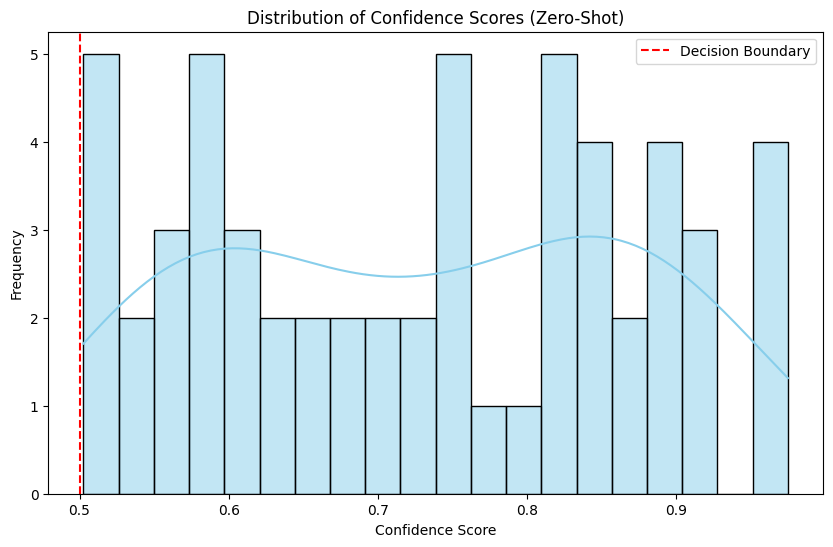

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(text_test_df['confidence_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Confidence Scores (Zero-Shot)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

The confidence distribution histogram reveals that the model's confidence scores are spread across a wide range, from 0.5 to 0.9.

There is no single dominant peak, but there are two slight peaks around 0.5 (uncertain) and 0.8 (confident).

The model frequently makes predictions with relatively high confidence (0.7 to 0.9), but it also has a notable cluster of predictions near the decision boundary (0.5), where it is less certain.

The wavy shape of the KDE line suggests that the model's confidence is somewhat inconsistent.

### Confidence by Correct/Incorrect Predictions

Average Confidence (Correct): 0.7712
Average Confidence (Incorrect): 0.6848


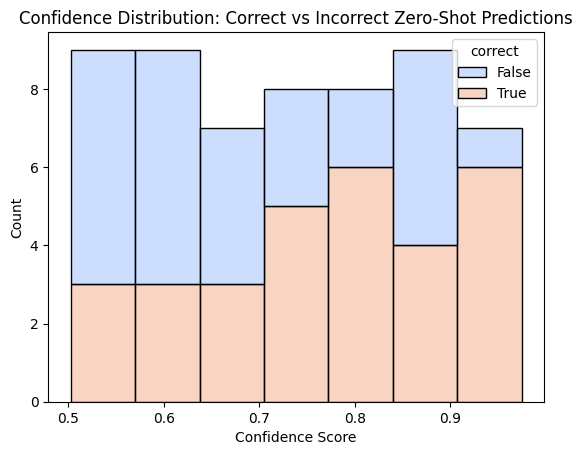

In [46]:
# Create a column indicating if the prediction was correct
correct_conf = text_test_df[text_test_df['correct'] == True]['confidence_score'].mean()
incorrect_conf = text_test_df[text_test_df['correct'] == False]['confidence_score'].mean()
print(f"Average Confidence (Correct): {correct_conf:.4f}")
print(f"Average Confidence (Incorrect): {incorrect_conf:.4f}")

# Plot confidence scores for correct vs incorrect predictions
sns.histplot(data=text_test_df, x='confidence_score', hue='correct',
             multiple='stack', palette="coolwarm", alpha=0.6)
plt.title("Confidence Distribution: Correct vs Incorrect Zero-Shot Predictions")
plt.xlabel("Confidence Score")
plt.show()

Lower confidence score are associated with fewer correct predictions.
This is expected, as the model is more "unsure" and less reliable at lower confidence levels.

At higher confidence scores, correct predictions become more frequent, but there are still several incorrect predictions - indicating that the model can be overconfident in its wrong answers.

- Average Confidence (Correct): 0.7712 - The model is reasonably confident when it is correct.
- Average Confidence (Incorrect): 0.6848 - The model is still fairly confident even when it is wrong, which is problematic.

### Precision-Recall Curve

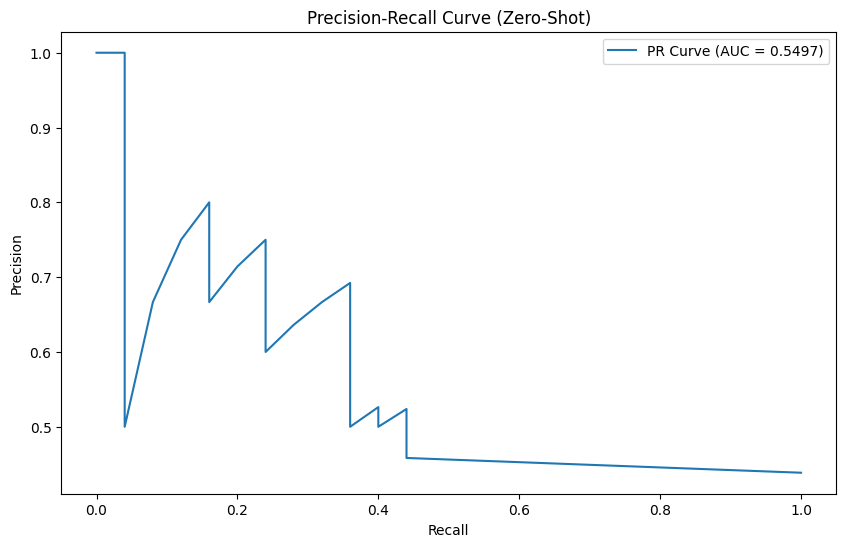

In [47]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision-recall for sarcasm (class 1)
precision, recall, _ = precision_recall_curve(
    text_test_df['sarcasm_label'],
    text_test_df['confidence_score'] * text_test_df['zero_shot_prediction_numeric']  # Use confidence only for positive class
)

# Calculate area under the curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.title("Precision-Recall Curve (Zero-Shot)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

The Precision-Recall (PR) curve visualizes the trade-off between precision and recall for detecting sarcastic reviews using the zero-shot model. As recall increases (capturing more sarcastic reviews), precision decreases, indicating that the model misclassifies more non-sarcastic reviews as sarcastic.

The area under the curve (AUC) is 0.5497, which is only slightly above 0.5, suggesting that the model is close to random guessing for this task. The sharp fluctuations in the curve show that the model's performance is inconsistent, likely because it lacks any training specifically for sarcasm detection.

These results highlight the model's difficulty in maintaining high precision without sacrificing recall and confirm the need for fine-tuning or few-shot learning.

### Confusion Matrix

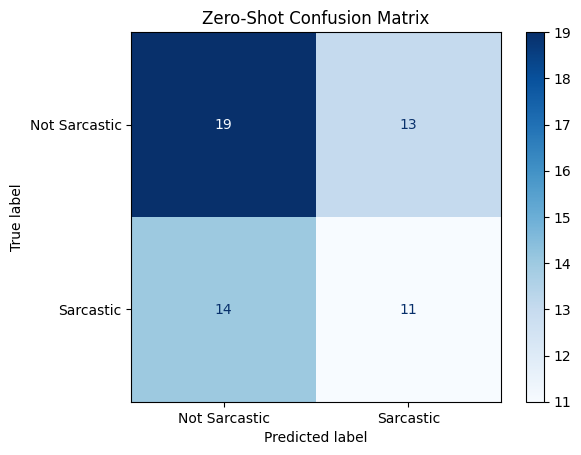

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(
    text_test_df['sarcasm_label'],
    text_test_df['zero_shot_prediction_numeric']
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Sarcastic", "Sarcastic"])
disp.plot(cmap="Blues")
plt.title("Zero-Shot Confusion Matrix")
plt.show()

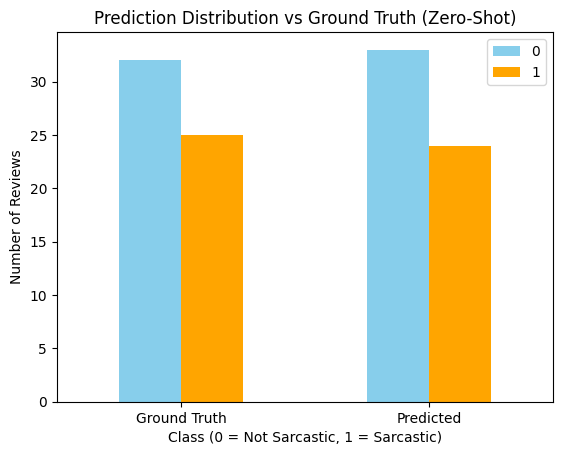

In [49]:
import matplotlib.pyplot as plt

# Count the ground truth labels
ground_truth_counts = text_test_df['sarcasm_label'].value_counts()
predicted_counts = text_test_df['zero_shot_prediction_numeric'].value_counts()

# Combine into a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Ground Truth': ground_truth_counts,
    'Predicted': predicted_counts
}).T

# Plot the distribution
comparison_df.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Prediction Distribution vs Ground Truth (Zero-Shot)")
plt.xticks(rotation=0)
plt.xlabel("Class (0 = Not Sarcastic, 1 = Sarcastic)")
plt.ylabel("Number of Reviews")
plt.show()

Although the predicted distribution is relatively close to the actual distribution, the model shows a slight tendency to over-predict "not sarcastic" reviews (blue), while slightly under-predicting "sarcastic" ones (orange). This indicates a minor bias towards the non-sarcastic class, which is common when the model is more confident in its safer predictions

### Confidence by Prediction Type

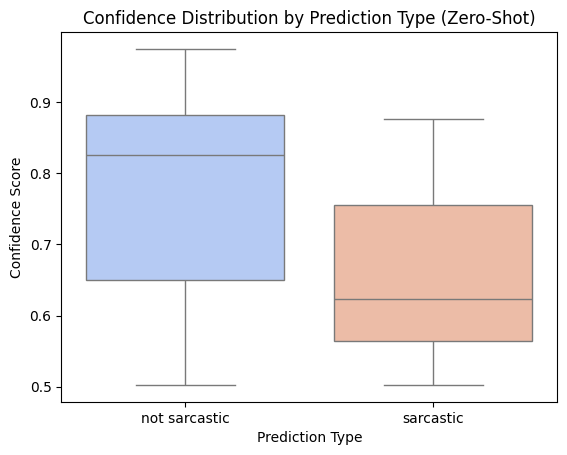

In [50]:
sns.boxplot(
    x='zero_shot_prediction',
    y='confidence_score',
    data=text_test_df,
    hue='zero_shot_prediction',
    palette="coolwarm"
)
plt.title("Confidence Distribution by Prediction Type (Zero-Shot)")
plt.xlabel("Prediction Type")
plt.ylabel("Confidence Score")
plt.show()

The box plot indicates that the model tends to be more confident in its predictions of "not sarcastic" reviews compared to "sarcastic" ones. This is shown by the higher median confidence score for "not sarcastic" predictions, while the "sarcastic" predictions have a lower median and a narrower range.

This pattern is consistent with the model's overall behavior, where it more frequently predicts "not sarcastic." Such an imbalance in predictions can naturally lead to greater confidence in the majority class, even if the model is not necessarily more accurate.

## One Shot

In [ ]:
# One-Shot Training Data Preparation
one_shot_train_df = pd.concat([
    text_train_df[text_train_df['sarcasm_label'] == 0].sample(1, random_state=42),
    text_train_df[text_train_df['sarcasm_label'] == 1].sample(1, random_state=42)
])

print("\nOne-Shot Training Data:")
print(one_shot_train_df)


# OLDER

## One Shot

In [ ]:
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline('zero-shot-classification', model='FacebookAI/roberta-large-mnli')

# Define your labels
candidate_labels = ['sarcastic', 'non-sarcastic']

# One-shot examples (one for each class)
sarcastic_example = "This game is so optimized it only crashes every 5 minutes instead of every 2! Amazing work devs!"
non_sarcastic_example = "Great gameplay mechanics and interesting story. Really enjoyed the character development."

# Function for one-shot classification
def one_shot_classify(review_text):
    # Create prompts combining examples with the review to classify
    sarcastic_prompt = f"Example of sarcastic review: {sarcastic_example}\nIs this review sarcastic too? Review: {review_text}"
    non_sarcastic_prompt = f"Example of non-sarcastic review: {non_sarcastic_example}\nIs this review non-sarcastic too? Review: {review_text}"

    # Get predictions for both prompts
    sarcastic_result = classifier(sarcastic_prompt, candidate_labels=['yes', 'no'])
    non_sarcastic_result = classifier(non_sarcastic_prompt, candidate_labels=['yes', 'no'])

    # Compare confidence scores for "yes" between the two prompts
    sarcastic_score = sarcastic_result['scores'][0] if sarcastic_result['labels'][0] == 'yes' else 1 - sarcastic_result['scores'][0]
    non_sarcastic_score = non_sarcastic_result['scores'][0] if non_sarcastic_result['labels'][0] == 'yes' else 1 - non_sarcastic_result['scores'][0]

    # Determine final prediction
    if sarcastic_score > non_sarcastic_score:
        return "sarcastic", sarcastic_score
    else:
        return "non-sarcastic", non_sarcastic_score

# Apply to your dataset
sample_reviews = steam_reviews.head(10)  # Adjust sample size as needed
predictions = []
confidence_scores = []

for review in sample_reviews['review_text']:
    label, score = one_shot_classify(review)
    predictions.append(label)
    confidence_scores.append(score)

# Add predictions to the DataFrame
sample_reviews['predicted_label'] = predictions
sample_reviews['confidence_score'] = confidence_scores

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...   non-sarcastic   
2                      This game saved my virginity.       sarcastic   
3  • Do you like original games? • Do you like ga...   non-sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.       sarcastic   
6          Still better than Call of Duty: Ghosts...       sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...       sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...   non-sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.395767  
1          0.568797  
2          0.408487  
3          0.635216  
4          0.475525  
5          0.333020  
6          0.435623  
7          0.455990  
8        

<ipython-input-11-a73c62d05391>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['predicted_label'] = predictions
<ipython-input-11-a73c62d05391>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['confidence_score'] = confidence_scores


In [ ]:
sample_reviews['review_text'][7]

'cant buy skins, cases, keys, stickers - gaben cant steal our money 10/10 would play again'

# NEW

## Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

## Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read the CSV file
dataset_path = '/content/drive/MyDrive/Masters Degree/NLP Course/Steam Reviews Sarcasm Detection Project/dataset/dataset.csv'
steam_reviews = pd.read_csv(dataset_path, nrows=60000)

# Display the first few rows
steam_reviews.head()

# Create a dataset batch for annotation
steam_reviews_annotated = steam_reviews

# Add an empty annotation column
steam_reviews_annotated['sarcasm_label'] = None

# Save to a new CSV for annotation
steam_reviews_annotated.to_csv('steam_reviews_for_annotation.csv', index=False)


Mounted at /content/drive


## Load Roberta Large mnli Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline

# Load pre-trained model and tokenizer
model_name = "roberta-large-mnli"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Zero Shot Inference

In [ ]:
# Create classifier pipeline using explicit components
classifier = pipeline(
    "zero-shot-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

# Define labels and processing function
candidate_labels = ['sarcastic', 'non-sarcastic']
hypothesis_template = "This review is {}."

def predict_sarcasm(review_text):
    result = classifier(
        review_text,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        multi_label=False
    )
    return result['labels'][0], result['scores'][0]

# Process sample reviews
sample_reviews = steam_reviews.head(10).copy()
sample_reviews[['predicted_label', 'confidence_score']] = sample_reviews['review_text'].apply(
    lambda x: pd.Series(predict_sarcasm(x))
)

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])

Device set to use cuda:0


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...   non-sarcastic   
2                      This game saved my virginity.   non-sarcastic   
3  • Do you like original games? • Do you like ga...   non-sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.   non-sarcastic   
6          Still better than Call of Duty: Ghosts...   non-sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...   non-sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...   non-sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.765970  
1          0.740014  
2          0.962879  
3          0.891574  
4          0.529092  
5          0.787967  
6          0.738280  
7          0.791888  
8        

## One Shot Inference

In [ ]:
one_shot_examples = {
    "sarcastic": {
        "text": "This game is so optimized it only crashes every 5 minutes instead of every 2! Amazing work devs!",
        "label": "sarcastic"
    },
    "non-sarcastic": {
        "text": "Great gameplay mechanics and interesting story. Really enjoyed the character development.",
        "label": "non-sarcastic"
    }
}


In [ ]:
def one_shot_predict(review_text, candidate_labels):
    # Construct prompt with example and target review
    prompt_template = f"""
    Example 1 ({one_shot_examples['sarcastic']['label']}): {one_shot_examples['sarcastic']['text']}
    Example 2 ({one_shot_examples['non-sarcastic']['label']}): {one_shot_examples['non-sarcastic']['text']}
    Now classify: {review_text}
    """

    # Use the same zero-shot pipeline
    result = classifier(
        prompt_template,
        candidate_labels=candidate_labels,
        hypothesis_template="This review is {}."
    )
    return result['labels'][0], result['scores'][0]


In [ ]:
# Process sample reviews
sample_reviews = steam_reviews.head(10).copy()

# Predict using one-shot
sample_reviews[['predicted_label', 'confidence_score']] = sample_reviews['review_text'].apply(
    lambda x: pd.Series(one_shot_predict(x, candidate_labels=['sarcastic', 'non-sarcastic']))
)

# Display results
print(sample_reviews[['review_text', 'predicted_label', 'confidence_score']])


                                         review_text predicted_label  \
0                                    Ruined my life.       sarcastic   
1  This will be more of a ''my experience with th...       sarcastic   
2                      This game saved my virginity.   non-sarcastic   
3  • Do you like original games? • Do you like ga...       sarcastic   
4           Easy to learn, hard to master.                 sarcastic   
5             No r8 revolver, 10/10 will play again.       sarcastic   
6          Still better than Call of Duty: Ghosts...   non-sarcastic   
7  cant buy skins, cases, keys, stickers - gaben ...       sarcastic   
8  Counter-Strike: Ok, after 9 years of unlimited...       sarcastic   
9  Every server is spanish or french. I can now f...       sarcastic   

   confidence_score  
0          0.560238  
1          0.541181  
2          0.514453  
3          0.843760  
4          0.630184  
5          0.501393  
6          0.546452  
7          0.632201  
8        

# Review Text With Metadata And Additional Features Experiment